In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import chime
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
%load_ext chime 

# Comparison of halving search with other  hyperparameter optimization algorithms

# Classification
Data: Reservation Cancellation Prediction dataset

https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction

Classifier: XGBoost

# Data preparation

In [3]:
train = pd.read_csv('./data/train.csv', index_col='id'); train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1
42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0
42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0


In [4]:
X_train = train.drop(columns='booking_status')
y_train = train.booking_status

In [5]:
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), 
                       columns=X_train.columns, 
                       index=X_train.index)
X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
id,,,,,,,,,,,,,,,,,
0,0.151040,-0.313454,-0.998814,-0.278849,1.294624,-0.160945,-0.515173,-1.170469,0.409661,-2.330398,-0.214091,0.428551,5.766758,33.699120,-0.101479,-0.998052,-0.737691
1,0.151040,-0.313454,0.130259,-0.278849,-0.407020,-0.160945,-0.515173,0.161740,0.409661,-0.209778,1.473487,-1.149928,-0.173408,-0.060506,-0.101479,-0.870153,-0.737691
2,0.151040,-0.313454,-0.998814,-0.979466,-0.407020,-0.160945,-0.515173,2.604122,0.409661,1.557404,-1.564154,-1.149928,-0.173408,-0.060506,-0.101479,-1.415406,-0.737691
3,-1.753925,-0.313454,-0.998814,-0.278849,1.294624,-0.160945,-0.515173,-0.886758,0.409661,1.557404,-1.676659,0.428551,-0.173408,-0.060506,-0.101479,-1.307702,-0.737691
4,0.151040,-0.313454,0.130259,-1.680084,-0.407020,-0.160945,-0.515173,1.901012,0.409661,0.850531,0.010919,-1.149928,-0.173408,-0.060506,-0.101479,-0.122955,-0.737691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,2.056005,-0.313454,-0.998814,1.122386,-0.407020,-0.160945,0.685890,0.692156,0.409661,1.557404,1.585992,0.428551,-0.173408,-0.060506,-0.101479,0.954088,1.842849
42096,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,-0.515173,-0.862087,-2.441040,0.497095,0.798456,-1.149928,-0.173408,-0.060506,-0.101479,3.233919,-0.737691
42097,0.151040,-0.313454,-0.998814,-0.278849,2.996268,-0.160945,-0.515173,2.320411,0.409661,-0.209778,0.573445,-1.149928,-0.173408,-0.060506,-0.101479,-0.230659,-0.737691


## Comparison
- All tests will use cross-validation score (ROC AUC) with 5 folds.
- To make sure the results are comparable, I used n_jobs=-1 in the estimator and n_jobs=1 in the search algorithm in all tests.
- The main risk is missing the best hyperparameter set in an early iteration when sample size is small. So the min_resources parameter needs to be selected with care.

In [6]:
xgboost_clf = XGBClassifier(random_state=8,
                         max_leaves=0,
                         n_jobs=-1)

In [10]:
params = {
    'n_estimators': np.logspace(1, 3, num=5, endpoint=True, base=10.0, dtype=int).tolist(),
    'max_depth': [2, 3, 4, 5],
    'learning_rate': np.logspace(-1, 0, num=5, endpoint=True, base=10.0).tolist(),
    'reg_alpha': np.logspace(-4, 0, num=5, endpoint=True, base=10.0).tolist(),
    'reg_lambda': np.logspace(-4, 0, num=5, endpoint=True, base=10.0).tolist()
}
params

{'n_estimators': [10, 31, 100, 316, 1000],
 'max_depth': [2, 3, 4, 5],
 'learning_rate': [0.1,
  0.1778279410038923,
  0.31622776601683794,
  0.5623413251903491,
  1.0],
 'reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'reg_lambda': [0.0001, 0.001, 0.01, 0.1, 1.0]}

### Grid Search 

In [11]:
model = GridSearchCV(estimator=xgboost_clf,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                     verbose = 3,
                    n_jobs=1)

In [12]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.816 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.835 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.823 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.836 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.826 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.001;, score=0.816 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.001;, score=0.835 total time=   0.1s
[CV 3/5] END learni

[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.835 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.823 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.836 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.826 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.816 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.835 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.823 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.836 total time=

[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.861 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.854 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.863 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.855 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.849 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.861 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.854 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.

[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.849 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.861 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.854 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.863 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.855 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.849 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.861 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.854 total

[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.866 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.877 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.870 total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.879 total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.870 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.866 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.876 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=

[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.870 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.866 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.876 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.870 total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.879 total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.870 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001;, score=0.866 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001;, sco

[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.879 total time=   1.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.877 total time=   1.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.887 total time=   1.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.882 total time=   1.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.889 total time=   1.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.879 total time=   1.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.877 total time=   1.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;

[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.890 total time=   1.2s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.879 total time=   1.2s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.877 total time=   1.2s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.887 total time=   1.2s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.882 total time=   1.3s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.890 total time=   1.2s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.879 total time=   1.2s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.01;, score=

[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.893 total time=   3.7s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.898 total time=   3.5s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.889 total time=   3.7s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.887 total time=   3.5s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.897 total time=   3.5s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.893 total time=   3.6s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.898 total time=   3.5s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lamb

[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.897 total time=   3.7s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.892 total time=   3.5s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.899 total time=   3.6s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.889 total time=   3.5s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.888 total time=   3.7s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.897 total time=   3.5s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.893 total time=   3.7s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, sco

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.838 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.854 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.844 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.856 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.847 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.838 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.854 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, s

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.854 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.844 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.856 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.847 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.838 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.854 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.844 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.856 total time=   0

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.870 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.864 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.874 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.865 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.001;, score=0.858 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.001;, score=0.870 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.001;, score=0.864 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.870 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.863 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.875 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.865 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.859 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.870 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.864 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.875 total time=   0.2s


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.883 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.879 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.886 total time=   0.5s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.877 total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01;, score=0.872 total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01;, score=0.883 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01;, score=0.879 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.871 total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.884 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.879 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.887 total time=   0.5s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.876 total time=   0.5s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.872 total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.883 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.879 to

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.887 total time=   1.7s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.884 total time=   1.7s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.895 total time=   1.7s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.890 total time=   1.7s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.897 total time=   1.7s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.888 total time=   1.7s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.884 total time=   1.7s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, 

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.887 total time=   1.7s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.884 total time=   1.7s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.895 total time=   1.7s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.890 total time=   1.7s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.896 total time=   1.7s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.888 total time=   1.7s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.884 total time=   1.7s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, scor

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.902 total time=   4.9s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.894 total time=   4.8s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.892 total time=   4.8s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.902 total time=   4.9s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.898 total time=   4.9s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.902 total time=   4.8s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.894 total time=   5.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0

[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.898 total time=   4.9s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.902 total time=   4.9s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.895 total time=   4.8s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.893 total time=   4.9s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.903 total time=   4.8s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.898 total time=   5.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.902 total time=   5.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.00

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.869 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.859 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.872 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.863 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.853 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.869 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.859 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.872 tot

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.869 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.859 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.872 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.862 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.01;, score=0.853 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.01;, score=0.869 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.01;, score=0.859 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.01;, score=0.872 total t

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.880 total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.872 total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.882 total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.873 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.866 total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.880 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.872 total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.879 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.872 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.883 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.873 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.1;, score=0.865 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.1;, score=0.879 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.1;, score=0.872 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.1;, score=0.882 total time=   0

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.878 total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.889 total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.884 total time=   0.7s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.893 total time=   0.7s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.883 total time=   0.7s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.878 total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.889 total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.877 total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.889 total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.884 total time=   0.7s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.892 total time=   0.7s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.882 total time=   0.7s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.877 total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.889 total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.884 total time=

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.892 total time=   2.1s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.889 total time=   2.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.900 total time=   2.1s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.895 total time=   2.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.900 total time=   2.2s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.892 total time=   2.1s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.889 total time=   2.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, 

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.892 total time=   2.1s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.889 total time=   2.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   2.1s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.895 total time=   2.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   2.1s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.892 total time=   2.1s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.893 total time=   6.4s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.9

[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.899 total time=   6.2s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.902 total time=   6.4s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.894 total time=   6.3s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.01;, score=0.893 total time=   6.3s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.01;, score=0.903 total time=   6.2s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.01;, score=0.898 total time=   6.3s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.01;, score=0.902 total time=   6.2s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.903 total time=   6.4s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   6.3s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.903 total time=   6.3s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.895 total time=   6.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.862 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.867 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;,

[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.867 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.879 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.868 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.861 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.867 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.879 total t

[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.885 total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.878 total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.888 total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.878 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.871 total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.885 total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.878 total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_la

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.871 total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.885 total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.878 total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.888 total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.878 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.872 total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.884 total time=   0.3s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.878 total time=

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.883 total time=   0.8s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.894 total time=   0.9s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.889 total time=   1.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.897 total time=   0.8s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.887 total time=   0.9s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.882 total time=   0.8s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.894 total time=   0.8s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_

[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.887 total time=   0.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.883 total time=   0.8s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.894 total time=   0.8s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.888 total time=   0.8s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.896 total time=   0.8s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.887 total time=   0.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.883 total time=   0.8s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.894

[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.893 total time=   2.6s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.890 total time=   2.6s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.902 total time=   2.6s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.897 total time=   2.6s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.902 total time=   2.6s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.892 total time=   2.6s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.890 total time=   2.7s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambd

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=1.0;, score=0.901 total time=   2.6s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=1.0;, score=0.894 total time=   2.6s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.891 total time=   2.6s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.901 total time=   2.6s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.897 total time=   2.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.902 total time=   2.6s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.893 total time=   2.6s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, scor

[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.898 total time=   7.8s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.900 total time=   7.8s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.891 total time=   7.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.891 total time=   7.7s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.901 total time=   7.7s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.898 total time=   7.8s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.900 total time=   7.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_l

[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.900 total time=   7.9s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.897 total time=   7.8s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.900 total time=   7.8s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.892 total time=   7.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.891 total time=   7.8s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.901 total time=   7.8s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.897 total time=   7.8s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.833 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.849 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.840 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.851 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.841 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.833 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.849 total time=   0.1s

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.833 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.849 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.840 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.851 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.841 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.833 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.849 total time=   0.1s
[

[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.864 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.858 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.871 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.864 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.873 total time=   0.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.864 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.858 total time=

[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.864 total time=   0.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.873 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.864 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.858 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.872 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.864 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.874 total time=   0.2s
[CV 5/5] END 

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.881 total time=   0.4s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.876 total time=   0.4s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.884 total time=   0.4s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.874 total time=   0.4s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.871 total time=   0.4s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.881 total time=   0.4s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.884 total time=   0.4s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.874 total time=   0.4s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.871 total time=   0.4s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.881 total time=   0.4s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.876 total time=   0.4s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.884 total time=   0.4s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.874 total time=   0.

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.882 total time=   0.4s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.876 total time=   0.4s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.885 total time=   0.4s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.874 total time=   0.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.871 total time=   0.4s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.881 total time=   0.5s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.876 total time=   0.5s
[CV 4/5] END 

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.894 total time=   1.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.885 total time=   1.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.883 total time=   1.2s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.893 total time=   1.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.888 total time=   1.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.894 total time=   1.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.886 total ti

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.893 total time=   1.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.888 total time=   1.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.894 total time=   1.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.886 total time=   1.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.883 total time=   1.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.893 total time=   1.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.888 total time=   1.2s
[C

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.901 total time=   3.8s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.893 total time=   3.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.891 total time=   3.6s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.900 total time=   3.6s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.896 total time=   3.6s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.901 total time=   3.5s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.893 total tim

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.891 total time=   3.5s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.900 total time=   3.5s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.896 total time=   3.6s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.901 total time=   3.6s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.892 total time=   3.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.891 total time=   3.6s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.900 total time=   3.5s


[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.858 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.848 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.859 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.853 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.866 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.858 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.848 total time=

[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.858 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.848 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.859 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.854 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.866 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.858 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=1.0;, score=0.848 total time=   0.1s
[CV 2/5] END learni

[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.873 total time=   0.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.881 total time=   0.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.872 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.866 total time=   0.2s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.878 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.873 total time=   0.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.881 total time

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.878 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.873 total time=   0.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.881 total time=   0.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.872 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.866 total time=   0.2s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.878 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.873 total time=   0.2s
[CV 4/5] 

[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.883 total time=   0.5s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.879 total time=   0.5s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.890 total time=   0.5s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.885 total time=   0.5s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.893 total time=   0.5s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.883 total time=   0.5s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=1.0;, score=0.878 total time

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.889 total time=   0.5s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.886 total time=   0.5s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.892 total time=   0.5s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.883 total time=   0.5s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.878 total time=   0.5s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.890 total time=   0.5s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.886 total time=   0.5s


[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.892 total time=   1.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.890 total time=   1.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.899 total time=   1.7s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.895 total time=   1.6s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.901 total time=   1.6s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.892 total time=   1.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.8

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.900 total time=   1.8s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.896 total time=   1.8s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.900 total time=   1.7s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.892 total time=   1.7s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.890 total time=   1.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.899 total time=   1.7s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.895 total time=   1.7s
[C

[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.893 total time=   1.7s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.889 total time=   1.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.899 total time=   1.6s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.895 total time=   1.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   1.6s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.892 total time=   1.7s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.894 total time=   4.9s
[CV 2/

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.903 total time=   4.9s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.898 total time=   5.0s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.902 total time=   4.8s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.895 total time=   5.0s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.894 total time=   4.8s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.903 total time=   4.8s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.898 

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.903 total time=   4.8s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.896 total time=   4.8s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.895 total time=   4.8s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.904 total time=   4.8s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.900 total time=   4.9s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.903 total time=   4.9s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.896 total time=   4.

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.877 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.866 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.860 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.874 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.863 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.877 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.866 total time=   0.1s
[CV 1/

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.877 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.866 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.859 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.873 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.865 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.877 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.866 total time=   0.1s
[CV 

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.885 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.879 total time=   0.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.888 total time=   0.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.878 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.873 total time=   0.2s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.885 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.879 total time=   0.3s
[C

[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.877 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.872 total time=   0.2s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.885 total time=   0.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.878 total time=   0.2s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.888 total time=   0.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.878 total time=   0.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=0.0001;, score=0.872 total time=   0.2s
[CV 2/5] END lear

[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.891 total time=   0.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.898 total time=   0.7s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.889 total time=   0.7s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.884 total time=   0.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.896 total time=   0.7s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.891 total time=   0.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.898 t

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.885 total time=   0.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.895 total time=   0.7s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.891 total time=   0.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.897 total time=   0.7s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.888 total time=   0.7s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.885 total time=   0.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.896 total time=   0.7s
[CV 3/5]

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.903 total time=   2.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.893 total time=   2.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.892 total time=   2.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.902 total time=   2.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.897 total time=   2.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.902 total time=   2.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.895 total time=

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.892 total time=   2.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.902 total time=   2.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.897 total time=   2.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.902 total time=   2.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.894 total time=   2.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.891 total time=   2.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.902 total time=  

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.001;, score=0.900 total time=   6.3s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.001;, score=0.893 total time=   6.3s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.893 total time=   6.2s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.900 total time=   6.3s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.898 total time=   6.4s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.899 total time=   6.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.892 total time=   6.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.900 total time=   6.2s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.897 total time=   6.3s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.901 total time=   6.2s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.892 total time=   6.3s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=1.0;, score=0.893 total time=   6.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=1.0;, score=0.902 total time=   6.2s

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.901 total time=   6.3s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.894 total time=   6.2s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.865 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.880 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.871 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.882 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.872 total

[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.871 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.882 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.872 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.865 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.880 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.871 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.882 total time=   0.1s
[CV

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.865 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.880 total time=   0.1s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.870 total time=   0.1s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.882 total time=   0.1s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.872 total time=   0.1s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=1.0;, score=0.864 total time=   0.1s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=1.0;, score=0.879 total time=   0.1s
[CV 3/5] END learnin

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.892 total time=   0.3s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.881 total time=   0.3s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.877 total time=   0.3s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.890 total time=   0.3s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.883 total time=   0.3s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.892 total time=   0.3s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.882 total time=   0

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.888 total time=   0.3s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.884 total time=   0.3s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.891 total time=   0.3s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.881 total time=   0.3s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.876 total time=   0.3s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.888 total time=   0.3s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.884 total time=   0.3s
[CV 4/5] 

[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01;, score=0.891 total time=   0.8s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.887 total time=   0.8s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.899 total time=   0.8s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.895 total time=   0.8s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.899 total time=   0.8s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.890 total time=   0.8s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.887 total time=   0.8

[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.894 total time=   0.8s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.899 total time=   0.8s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.891 total time=   0.8s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.888 total time=   0.8s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.898 total time=   0.8s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.894 total time=   0.8s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.900 total time=   0.8s
[

[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.891 total time=   2.6s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.900 total time=   2.6s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.898 total time=   2.6s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.901 total time=   2.6s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.893 total time=   2.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.892 total time=   2.6s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.900 total 

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.01;, score=0.901 total time=   2.6s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.01;, score=0.893 total time=   2.6s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.891 total time=   2.6s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.902 total time=   2.7s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.898 total time=   2.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.901 total time=   2.7s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.893 total time=   2.6s
[CV 1/5] EN

[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.897 total time=   7.7s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.895 total time=   7.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.896 total time=   7.7s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.891 total time=   7.7s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.0001;, score=0.888 total time=   7.7s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.0001;, score=0.895 total time=   8.6s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.0001;, score=0.89

[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.894 total time=   7.8s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.888 total time=   7.8s
[CV 1/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.887 total time=   7.8s
[CV 2/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.895 total time=   7.9s
[CV 3/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.893 total time=   7.7s
[CV 4/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.895 total time=   7.9s
[CV 5/5] END learning_rate=0.1778279410038923, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.888 total tim

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.862 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.853 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.863 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.854 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.845 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.862 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.853 total t

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.845 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.862 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.853 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.863 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.854 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.845 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.862 total time=   0.1s
[C

[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.869 total time=   0.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.866 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.877 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.870 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.879 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.869 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.8

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.870 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.879 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.869 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.866 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.877 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.870 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.879 total time=   0.1s
[CV

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.866 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.871 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.880 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.871 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.877 total time=   0.4s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.887 total time=   0.4s

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.884 total time=   0.4s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.890 total time=   0.4s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.880 total time=   0.4s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.877 total time=   0.4s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.887 total time=   0.4s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.884 total time=   0.4s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.890 t

[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.001;, score=0.880 total time=   0.4s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.878 total time=   0.4s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.888 total time=   0.4s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.884 total time=   0.4s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.890 total time=   0.4s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.880 total time=   0.4s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.879 total time=   0.4s

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.897 total time=   1.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.894 total time=   1.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.899 total time=   1.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.890 total time=   1.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.888 total time=   1.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.896 total time=   1.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.894 total time=

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.899 total time=   1.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.890 total time=   1.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.888 total time=   1.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.897 total time=   1.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.894 total time=   1.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.899 total time=   1.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.890 total time

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.893 total time=   3.6s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.902 total time=   3.6s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.898 total time=   3.7s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.902 total time=   3.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.894 total time=   3.6s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.892 total time=   3.6s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, scor

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.898 total time=   3.6s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.902 total time=   3.6s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.894 total time=   3.8s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.893 total time=   3.7s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.902 total time=   3.7s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.898 total time=   3.8s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=2, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.902 total time=   3

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.858 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.870 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.861 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.874 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.865 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.858 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.870 total t

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.861 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.874 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.865 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.858 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.870 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.861 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.874 total time=   0

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.872 total time=   0.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.884 total time=   0.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.878 total time=   0.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.888 total time=   0.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.877 total time=   0.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.871 total time=   0.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.883 total 

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.879 total time=   0.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.888 total time=   0.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.877 total time=   0.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.872 total time=   0.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.883 total time=   0.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.878 total time=   0.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.886 total time=   0.2s
[CV 5/

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.885 total time=   0.5s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.895 total time=   0.5s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.890 total time=   0.5s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.897 total time=   0.5s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.888 total time=   0.5s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.885 total time=   0.5s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.890 total time=   0.5s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.896 total time=   0.5s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.888 total time=   0.5s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.885 total time=   0.5s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.896 total time=   0.5s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.891 total time=   0.5s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.896 total ti

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.886 total time=   0.5s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.895 total time=   0.5s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.891 total time=   0.5s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.896 total time=   0.5s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.889 total time=   0.5s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.884 total time=   0.5s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.895 total time=   0.5s
[CV 3/

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.897 total time=   1.7s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.901 total time=   1.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.894 total time=   1.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.893 total time=   1.7s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.902 total time=   1.7s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.898 total time=   1.7s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.902 tot

[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.896 total time=   1.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.892 total time=   1.7s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.902 total time=   1.8s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.899 total time=   1.7s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.902 total time=   1.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.896 total time=   1.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.892 total time=

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.902 total time=   5.0s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.897 total time=   4.9s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.900 total time=   5.0s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.892 total time=   4.9s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.893 total time=   5.0s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.902 total time=   4.9s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.897 

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.900 total time=   5.0s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.894 total time=   4.9s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.893 total time=   4.9s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.903 total time=   4.9s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.898 total time=   4.8s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.901 total time=   4.9s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.895 total time=   4.8s

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.879 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.873 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.882 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.873 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.864 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.879 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.873 

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.865 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.879 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.873 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.882 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.873 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.865 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.879 total time=   0.1s
[CV 3/5]

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.891 total time=   0.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.883 total time=   0.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.878 total time=   0.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.889 total time=   0.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.885 total time=   0.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.892 total time=   0.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.883 total time=

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.879 total time=   0.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.891 total time=   0.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.885 total time=   0.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.892 total time=   0.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.882 total time=   0.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.879 total time=   0.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.891 total time=  

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.899 total time=   0.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.891 total time=   0.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.888 total time=   0.7s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.899 total time=   0.7s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.894 total time=   0.7s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.899 total time=   0.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.887 total time=   0.7s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.900 total time=   0.7s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.894 total time=   0.6s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.899 total time=   0.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.891 total time=   0.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.887 total time=   0.8s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.900 total time=   0.7s

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.899 total time=   0.7s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.893 total time=   0.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.892 total time=   2.3s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.901 total time=   2.0s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.896 total time=   2.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.900 total time=   2.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.891 total time=   2.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.901 total time=   2.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.897 total time=   2.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.901 total time=   2.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.893 total time=   2.2s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.891 total time=   2.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.900 total 

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.901 total time=   2.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.895 total time=   2.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.892 total time=   2.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.902 total time=   2.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.899 total time=   2.2s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.901 total time=   2.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.895 total time=   2.2s
[CV 

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.889 total time=   6.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.896 total time=   6.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.894 total time=   6.4s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.896 total time=   6.2s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.890 total time=   6.3s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.887 total time=   6.3s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.894 

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.894 total time=   6.4s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.896 total time=   6.3s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.890 total time=   6.5s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.890 total time=   6.5s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.896 total time=   6.3s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.896 total time=   6.4s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.896 t

[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.877 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.869 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.885 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.879 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.887 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.877 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.870 total time=

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.879 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.887 total time=   0.1s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.1;, score=0.877 total time=   0.1s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=1.0;, score=0.871 total time=   0.1s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=1.0;, score=0.884 total time=   0.1s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=1.0;, score=0.877 total time=   0.1s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=1.0;, score=0.885 total time=   0.1s
[CV 5/5] END 

[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.882 total time=   0.3s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.894 total time=   0.3s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.888 total time=   0.3s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.896 total time=   0.3s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.887 total time=   0.3s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.001;, score=0.882 total time=   0.3s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.001;, score=0.894

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.894 total time=   0.3s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.001;, score=0.887 total time=   0.4s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.882 total time=   0.3s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.893 total time=   0.3s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.889 total time=   0.3s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.894 total time=   0.3s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.887 total time=   0.3s
[CV 

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.900 total time=   0.8s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.896 total time=   0.8s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.899 total time=   0.8s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.1;, score=0.890 total time=   0.8s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=1.0;, score=0.890 total time=   0.8s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=1.0;, score=0.899 total time=   0.9s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=1.0;, score=0.896 tota

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.901 total time=   0.8s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.892 total time=   0.8s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.890 total time=   1.0s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.900 total time=   0.9s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.896 total time=   0.9s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.899 total time=   0.8s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.892 total ti

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.897 total time=   2.6s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.893 total time=   2.6s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.896 total time=   2.6s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.890 total time=   2.6s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.889 total time=   2.6s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.897 total time=   2.6s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score

[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.898 total time=   2.6s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.01;, score=0.890 total time=   2.6s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.890 total time=   2.6s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.897 total time=   2.6s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.895 total time=   2.6s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.897 total time=   2.6s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.1;, score=0.889 total time=   2.

[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.899 total time=   2.8s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.897 total time=   2.6s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.898 total time=   2.6s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.893 total time=   2.7s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.879 total time=   7.8s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.886 total time=   7.9s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.885 tota

[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.885 total time=   7.7s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.885 total time=   7.9s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.880 total time=   7.8s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.880 total time=   7.7s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.886 total time=   7.8s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.886 total time=   7.9s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=

[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.001;, score=0.884 total time=   8.0s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.882 total time=   8.2s
[CV 2/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.889 total time=   8.2s
[CV 3/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.888 total time=   8.0s
[CV 4/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.889 total time=   8.0s
[CV 5/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.01;, score=0.883 total time=   8.0s
[CV 1/5] END learning_rate=0.31622776601683794, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.1;, score=0.883 total time=

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.872 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.859 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.859 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.869 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.864 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.872 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=1.0;, score=0.859 total time=   0.1s
[CV 1/

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.864 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.872 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.859 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.859 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.869 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.864 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.872 total time=   0.1s
[CV

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.881 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.877 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.885 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.01;, score=0.873 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.871 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.880 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.877 total time=   0.2s
[C

[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.873 total time=   0.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.870 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.880 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.877 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.884 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=0.1, reg_lambda=1.0;, score=0.873 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.0001;, score=0.870 total time=   0.2s
[CV 2/5] END lear

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.889 total time=   0.4s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.894 total time=   0.4s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.885 total time=   0.4s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.884 total time=   0.4s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.893 total time=   0.4s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.889 total time=   0.4s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.894 t

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.883 total time=   0.4s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.893 total time=   0.4s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.888 total time=   0.4s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.894 total time=   0.4s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.884 total time=   0.4s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.883 total time=   0.4s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.893 total time=   0.4s
[CV 3/5]

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.899 total time=   1.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.1;, score=0.893 total time=   1.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.891 total time=   1.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.900 total time=   1.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.897 total time=   1.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.900 total time=   1.3s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.0001, reg_lambda=1.0;, score=0.892 total time=

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.891 total time=   1.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.900 total time=   1.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.895 total time=   1.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.899 total time=   1.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.890 total time=   1.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.891 total time=   1.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=316, reg_alpha=0.1, reg_lambda=0.001;, score=0.900 total time=  

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.001;, score=0.901 total time=   3.6s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.001;, score=0.892 total time=   3.6s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.893 total time=   3.6s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.902 total time=   3.6s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.899 total time=   3.6s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.901 total time=   3.6s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.894 total time=   3.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.902 total time=   3.5s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.898 total time=   3.6s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.900 total time=   3.6s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=0.893 total time=   3.6s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=1.0;, score=0.893 total time=   3.6s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=1.0;, score=0.902 total time=   3.6s

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.901 total time=   3.7s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.894 total time=   3.6s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.863 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.873 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.881 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.869 total

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.873 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.881 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.869 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.863 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.873 total time=   0.1s
[C

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.874 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.879 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=0.1;, score=0.870 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=1.0;, score=0.864 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=1.0;, score=0.876 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=10, reg_alpha=1.0, reg_lambda=1.0;, score=0.874 total time=   0.1s
[CV 4/5] END learnin

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.878 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.889 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.887 total time=   0.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.891 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.882 total time=   0.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.001;, score=0.878 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.001;, score=0.889 total time=  

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.889 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.882 total time=   0.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.878 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.889 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.886 total time=   0.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.889 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.882 total time=   0.2s
[CV 1/5] EN

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.888 total time=   0.5s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.897 total time=   0.5s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.895 total time=   0.5s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.898 total time=   0.5s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.890 total time=   0.5s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.887 total time=   0.5s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.897 total time=   0.6s

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.898 total time=   0.5s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.890 total time=   0.5s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.888 total time=   0.5s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.898 total time=   0.5s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.895 total time=   0.6s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.898 total time=   0.5s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0001;, score=0.892 total time=   0.5

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.890 total time=   1.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.899 total time=   1.7s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.897 total time=   1.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.900 total time=   1.7s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.893 total time=   1.7s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.890 total time=   1.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.001, reg_lambda=0.01;, score=0.901 total 

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.01;, score=0.899 total time=   1.7s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.01;, score=0.892 total time=   1.7s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.890 total time=   1.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.900 total time=   1.7s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.896 total time=   1.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.899 total time=   1.7s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.893 total time=   1.7s
[CV 1/5] EN

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.897 total time=   4.9s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.895 total time=   5.0s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.897 total time=   4.9s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=1.0;, score=0.891 total time=   5.0s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.0001;, score=0.888 total time=   4.9s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.0001;, score=0.893 total time=   4.9s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.0001;, score=0.89

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.895 total time=   5.0s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.888 total time=   4.9s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.888 total time=   5.0s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.895 total time=   5.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.893 total time=   4.9s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.894 total time=   4.9s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.889 total tim

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.883 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.878 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.886 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.875 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.873 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.883 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.877 total time=   

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.884 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.878 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.887 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.01, reg_lambda=1.0;, score=0.877 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.873 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.883 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.0001;, score=0.877 total time=   0.1s
[CV 4/5

[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.887 total time=   0.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.883 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.893 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.890 total time=   0.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.894 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.887 total time=   0.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.883 tota

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.890 total time=   0.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.895 total time=   0.3s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.886 total time=   0.3s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.883 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.893 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.889 total time=   0.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.895 total time=   0.2s
[CV 5/5] E

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.884 total time=   0.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.894 total time=   0.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.890 total time=   0.2s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.896 total time=   0.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=31, reg_alpha=1.0, reg_lambda=1.0;, score=0.887 total time=   0.2s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.888 total time=   0.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.898 total time=   0.7s
[CV 3/

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.895 total time=   0.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.896 total time=   0.7s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.890 total time=   0.7s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.889 total time=   0.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.898 total time=   0.7s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.895 total time=   0.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001;, score=0.896 total ti

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.889 total time=   0.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.897 total time=   0.7s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.896 total time=   0.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.898 total time=   0.7s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.893 total time=   0.7s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.890 total time=   0.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.900 total time=   0.7s
[CV 3/5]

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.893 total time=   2.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.896 total time=   2.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.1;, score=0.889 total time=   2.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.888 total time=   2.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.896 total time=   2.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.895 total time=   2.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.897 total time=   2.1s

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.888 total time=   2.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.897 total time=   2.7s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.896 total time=   2.8s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.896 total time=   2.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.0001;, score=0.890 total time=   2.3s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.887 total time=   2.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.896 total time=  

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.883 total time=   6.3s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.882 total time=   6.3s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.877 total time=   6.4s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.877 total time=   6.3s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.885 total time=   6.5s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.883 total time=   6.3s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.883 t

[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.01;, score=0.877 total time=   6.3s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.880 total time=   6.2s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.883 total time=   6.3s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.884 total time=   6.3s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.883 total time=   6.4s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.1;, score=0.879 total time=   6.3s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.881 total time=   6.5s
[CV 2

[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.882 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.890 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.881 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.874 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.885 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.883 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.0001;, score=0.889 total time

[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.875 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.886 total time=   0.1s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.884 total time=   0.1s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.889 total time=   0.1s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.880 total time=   0.1s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.875 total time=   0.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.886 total time=   0.1s
[CV 3/5]

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.895 total time=   0.3s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.01;, score=0.888 total time=   0.3s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.884 total time=   0.3s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.895 total time=   0.3s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.891 total time=   0.3s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.896 total time=   0.3s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.1;, score=0.889 total time=   0.

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.895 total time=   0.3s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.893 total time=   0.3s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.898 total time=   0.3s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.888 total time=   0.5s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.883 total time=   0.3s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.894 total time=   0.3s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=31, reg_alpha=0.1, reg_lambda=0.0001;, score=0.892 total time=   0.3s
[CV 4/5

[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.886 total time=   0.8s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.887 total time=   0.8s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.895 total time=   0.8s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.892 total time=   0.8s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.895 total time=   0.8s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.886 total time=   0.9s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.8

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.896 total time=   0.8s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.893 total time=   0.8s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.892 total time=   0.9s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01;, score=0.889 total time=   0.8s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.887 total time=   0.9s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.895 total time=   0.8s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.892 total time=   0.8s
[C

[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.893 total time=   0.8s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.890 total time=   0.8s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.899 total time=   0.8s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.896 total time=   0.8s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.898 total time=   0.9s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.891 total time=   0.8s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.881 total time=   2.9s
[CV 2/5

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.887 total time=   2.6s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.887 total time=   2.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.885 total time=   2.6s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.881 total time=   2.7s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.879 total time=   2.6s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.887 total time=   2.6s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.886 total t

[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.001;, score=0.884 total time=   2.6s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.883 total time=   2.7s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.890 total time=   2.6s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.887 total time=   2.7s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.892 total time=   2.6s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.883 total time=   2.7s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.883 total time=   2.6s
[CV 2/

[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.876 total time=   7.8s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.876 total time=   7.9s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.876 total time=   8.0s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.1;, score=0.870 total time=   7.9s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.872 total time=   7.9s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.878 total time=   7.8s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.001, reg_lambda=1.0;, score=0.878 total time=

[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.879 total time=   8.0s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.874 total time=   8.0s
[CV 1/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.874 total time=   8.1s
[CV 2/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.880 total time=   8.2s
[CV 3/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.877 total time=   8.3s
[CV 4/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.878 total time=   8.2s
[CV 5/5] END learning_rate=0.5623413251903491, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.873 total time

[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.863 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.874 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.868 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.875 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.867 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.864 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.874 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.86

[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.877 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.867 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.864 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.874 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.868 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.877 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.867 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=10, reg_alpha=1.0, reg_lambda=0.01;, score=0.864 to

[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.886 total time=   0.2s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.878 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.875 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.883 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.880 total time=   0.2s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.886 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.878 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=0.01, reg_lambda=0.0001;, score=0.875 t

[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.876 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.876 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.886 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.883 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.887 total time=   0.2s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.876 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.1;, score=0.876 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=31, reg_alpha=1.0, reg_lambda=0.1;, score=0.886 total time= 

[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.894 total time=   0.4s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.887 total time=   0.4s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.885 total time=   0.4s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.892 total time=   0.4s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.890 total time=   0.4s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.892 total time=   0.4s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.884 total time=   0.4s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.00

[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.892 total time=   0.4s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.886 total time=   0.4s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.886 total time=   0.4s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.895 total time=   0.4s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.892 total time=   0.4s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.895 total time=   0.4s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.886 total time=   0.4s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0;, score=0.887 total tim

[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.895 total time=   1.2s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.898 total time=   1.2s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.890 total time=   1.2s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.890 total time=   1.2s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.898 total time=   1.2s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.895 total time=   1.3s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.001;, score=0.896 total time=   1.3s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=0.01, reg_lambda=0.00

[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.896 total time=   1.2s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.900 total time=   1.2s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.892 total time=   1.2s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.892 total time=   1.2s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   1.2s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.896 total time=   1.2s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   1.2s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.893 total time=

[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.890 total time=   3.7s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.898 total time=   3.7s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.896 total time=   3.6s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.896 total time=   3.6s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.890 total time=   3.7s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.01;, score=0.890 total time=   3.6s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.01;, score=0.898 total time=   3.6s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=0.01, reg_lambda=0

[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.1;, score=0.893 total time=   3.7s
[CV 1/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.893 total time=   3.6s
[CV 2/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.902 total time=   3.6s
[CV 3/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.899 total time=   3.7s
[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.901 total time=   3.6s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.894 total time=   3.7s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.867 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.0001;, score=0

[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.001;, score=0.874 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.867 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.879 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.875 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.878 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.01;, score=0.874 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.867 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=10, reg_alpha=0.01, reg_lambda=0.1;, score=0.878 tota

[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.876 total time=   0.3s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.890 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.885 total time=   0.2s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.888 total time=   0.2s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.883 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.876 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_lambda=0.001;, score=0.890 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.0001, reg_l

[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.01;, score=0.883 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.875 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.890 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.889 total time=   0.2s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.888 total time=   0.2s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=0.1;, score=0.882 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.879 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=31, reg_alpha=0.01, reg_lambda=1.0;, score=0.891 total time

[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.885 total time=   0.5s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.884 total time=   0.5s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.895 total time=   0.5s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.891 total time=   0.5s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.893 total time=   0.5s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.001;, score=0.885 total time=   0.6s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.01;, score=0.884 total time=   0.5s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.0001, re

[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.892 total time=   0.5s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1;, score=0.888 total time=   0.6s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.886 total time=   0.5s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.895 total time=   0.5s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.892 total time=   0.5s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.895 total time=   0.5s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1.0;, score=0.889 total time=   0.5s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.0001;, score=0.883 t

[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.892 total time=   1.7s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.001;, score=0.885 total time=   1.7s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.883 total time=   1.7s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.890 total time=   1.7s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.888 total time=   1.7s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.890 total time=   1.7s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lambda=0.01;, score=0.886 total time=   1.7s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.0001, reg_lam

[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=1.0;, score=0.891 total time=   1.8s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=1.0;, score=0.894 total time=   1.7s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.01, reg_lambda=1.0;, score=0.888 total time=   1.7s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.881 total time=   1.7s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.893 total time=   1.7s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.890 total time=   1.7s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score=0.890 total time=   1.7s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=316, reg_alpha=0.1, reg_lambda=0.0001;, score

[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.883 total time=   4.8s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.883 total time=   5.0s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.884 total time=   4.9s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.01;, score=0.879 total time=   4.9s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.876 total time=   5.0s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.883 total time=   4.8s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_lambda=0.1;, score=0.883 total time=   4.9s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.0001, reg_

[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.875 total time=   5.1s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.883 total time=   5.0s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.884 total time=   4.9s
[CV 4/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.884 total time=   5.0s
[CV 5/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.0001;, score=0.878 total time=   5.0s
[CV 1/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.878 total time=   5.0s
[CV 2/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.001;, score=0.884 total time=   4.9s
[CV 3/5] END learning_rate=1.0, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.

[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.01;, score=0.874 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.872 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.888 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.879 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.884 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=0.1;, score=0.875 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=0.873 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.0001, reg_lambda=1.0;, score=

[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.872 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.888 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.880 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.884 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.001;, score=0.875 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.872 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.888 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=10, reg_alpha=0.1, reg_lambda=0.01;, score=0.880 total 

[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.881 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.890 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.889 total time=   0.2s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.890 total time=   0.2s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.0001, reg_lambda=1.0;, score=0.885 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.881 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, score=0.891 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.001, reg_lambda=0.0001;, s

[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.881 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.894 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.885 total time=   0.2s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.890 total time=   0.2s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.01;, score=0.881 total time=   0.2s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.882 total time=   0.2s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.893 total time=   0.2s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=31, reg_alpha=0.1, reg_lambda=0.1;, score=0.886 total time=   

[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.881 total time=   0.6s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.890 total time=   0.7s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.885 total time=   0.6s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.889 total time=   0.6s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.0001;, score=0.880 total time=   0.6s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.881 total time=   0.6s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001;, score=0.892 total time=   0.6s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.001, reg_l

[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.882 total time=   0.7s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.881 total time=   0.7s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.891 total time=   0.7s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.885 total time=   0.7s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.888 total time=   0.7s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1;, score=0.884 total time=   0.7s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.885 total time=   0.7s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0;, score=0.891 total time

[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.0001;, score=0.880 total time=   2.2s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.0001;, score=0.874 total time=   2.1s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.871 total time=   2.1s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.882 total time=   2.1s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.880 total time=   2.2s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.882 total time=   2.1s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lambda=0.001;, score=0.875 total time=   2.3s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.001, reg_lamb

[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.882 total time=   2.2s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.882 total time=   2.2s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=0.1;, score=0.876 total time=   2.2s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.881 total time=   2.2s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.885 total time=   2.2s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.885 total time=   2.2s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.885 total time=   2.1s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=316, reg_alpha=0.1, reg_lambda=1.0;, score=0.882 total time=

[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.870 total time=   6.4s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.867 total time=   6.4s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.870 total time=   6.4s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.001;, score=0.864 total time=   7.5s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.863 total time=   6.7s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.868 total time=   9.6s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_lambda=0.01;, score=0.871 total time=   8.2s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.001, reg_l

[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.869 total time=   6.9s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.875 total time=   6.7s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.875 total time=   7.4s
[CV 4/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.874 total time=   6.8s
[CV 5/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.0;, score=0.871 total time=   7.0s
[CV 1/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.871 total time=   6.8s
[CV 2/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=0.877 total time=   6.4s
[CV 3/5] END learning_rate=1.0, max_depth=4, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.0001;, score=

[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.001;, score=0.878 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.874 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.888 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.880 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.888 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.01;, score=0.877 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.875 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=0.001, reg_lambda=0.1;, score=0.

[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.877 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.889 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.885 total time=   0.1s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.890 total time=   0.1s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.0001;, score=0.877 total time=   0.1s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.877 total time=   0.1s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.889 total time=   0.1s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=10, reg_alpha=1.0, reg_lambda=0.001;, score=0.88

[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.877 total time=   0.3s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.887 total time=   0.3s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.883 total time=   0.3s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.890 total time=   0.3s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=0.1;, score=0.884 total time=   0.3s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.879 total time=   0.3s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.890 total time=   0.3s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=0.001, reg_lambda=1.0;, score=0.885 tot

[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.881 total time=   0.3s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.891 total time=   0.3s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.889 total time=   0.3s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.891 total time=   0.3s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.001;, score=0.882 total time=   0.3s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.880 total time=   0.3s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.890 total time=   0.3s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=31, reg_alpha=1.0, reg_lambda=0.01;, score=0.889 total 

[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1;, score=0.875 total time=   0.8s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.876 total time=   0.8s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.886 total time=   0.8s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.883 total time=   0.8s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.888 total time=   0.8s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.001, reg_lambda=1.0;, score=0.879 total time=   0.8s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, score=0.876 total time=   0.8s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.0001;, sco

[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.001;, score=0.878 total time=   0.8s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.876 total time=   0.8s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.887 total time=   0.8s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.887 total time=   0.8s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.884 total time=   0.8s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.01;, score=0.877 total time=   0.9s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.880 total time=   0.8s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1;, score=0.886 tota

[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.878 total time=   2.6s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.001, reg_lambda=1.0;, score=0.872 total time=   2.5s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.868 total time=   2.6s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.868 total time=   2.6s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.868 total time=   2.6s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.870 total time=   2.5s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.0001;, score=0.864 total time=   2.6s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=0.01, reg_lambda=0.00

[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.876 total time=   2.7s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.01;, score=0.870 total time=   2.7s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.872 total time=   2.7s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.880 total time=   2.7s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.876 total time=   2.6s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.876 total time=   2.7s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=0.1;, score=0.871 total time=   2.7s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=316, reg_alpha=1.0, reg_lambda=1.0;, score=0.874 total tim

[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.858 total time=   7.8s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.859 total time=   8.0s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.0001;, score=0.857 total time=   8.0s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.859 total time=   8.0s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.861 total time=   8.0s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.859 total time=   8.0s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.001;, score=0.863 total time=   8.0s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=0.01, reg_lam

[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.1;, score=0.871 total time=   8.2s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.1;, score=0.867 total time=   8.3s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.1;, score=0.869 total time=   8.2s
[CV 5/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.1;, score=0.865 total time=   8.2s
[CV 1/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.866 total time=   8.1s
[CV 2/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.871 total time=   8.2s
[CV 3/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.871 total time=   8.1s
[CV 4/5] END learning_rate=1.0, max_depth=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1.0;, score=0.870 tot

In [13]:
model.best_params_

{'learning_rate': 0.1778279410038923,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_alpha': 1.0,
 'reg_lambda': 0.01}

In [14]:
model.best_score_

0.899574982102347

### Halving Search

In [15]:
search = HalvingGridSearchCV(
    estimator=xgboost_clf,
    param_grid=params,
    factor=3,
    resource='n_samples',
    max_resources='auto',
    min_resources=4677,
    aggressive_elimination=True,
    cv=5,
    scoring='roc_auc',
    refit=True, 
    return_train_score=False,
    random_state=8, 
    n_jobs=1,
    verbose=1
)

In [16]:
%%time
%%chime
search.fit(X_train, y_train)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 3
min_resources_: 4677
max_resources_: 42100
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 2500
n_resources: 4677
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
----------
iter: 1
n_candidates: 834
n_resources: 4677
Fitting 5 folds for each of 834 candidates, totalling 4170 fits
----------
iter: 2
n_candidates: 278
n_resources: 4677
Fitting 5 folds for each of 278 candidates, totalling 1390 fits
----------
iter: 3
n_candidates: 93
n_resources: 4677
Fitting 5 folds for each of 93 candidates, totalling 465 fits
----------
iter: 4
n_candidates: 31
n_resources: 4677
Fitting 5 folds for each of 31 candidates, totalling 155 fits
----------
iter: 5
n_candidates: 11
n_resources: 4677
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 6
n_candidates: 4
n_resources: 14031
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 7
n_candidates

In [17]:
search.best_params_

{'learning_rate': 0.1778279410038923,
 'max_depth': 2,
 'n_estimators': 316,
 'reg_alpha': 1.0,
 'reg_lambda': 0.0001}

In [18]:
search.best_score_

0.8887401044617758

# Results
Halving search is much faster but the performance is a bit worse: ROC AUC=0.8887 vs. 0.8996 with regular grid search.

### Another try with smaller min_resources

In [21]:
search = HalvingGridSearchCV(
    estimator=xgboost_clf,
    param_grid=params,
    factor=3,
    resource='n_samples',
    max_resources='auto',
    min_resources=1559,
    aggressive_elimination=True,
    cv=5,
    scoring='roc_auc',
    refit=True, 
    return_train_score=False,
    random_state=8, 
    n_jobs=1,
    verbose=1
)

In [22]:
%%time
%%chime
search.fit(X_train, y_train)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 4
min_resources_: 1559
max_resources_: 42100
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 2500
n_resources: 1559
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
----------
iter: 1
n_candidates: 834
n_resources: 1559
Fitting 5 folds for each of 834 candidates, totalling 4170 fits
----------
iter: 2
n_candidates: 278
n_resources: 1559
Fitting 5 folds for each of 278 candidates, totalling 1390 fits
----------
iter: 3
n_candidates: 93
n_resources: 1559
Fitting 5 folds for each of 93 candidates, totalling 465 fits
----------
iter: 4
n_candidates: 31
n_resources: 1559
Fitting 5 folds for each of 31 candidates, totalling 155 fits
----------
iter: 5
n_candidates: 11
n_resources: 4677
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 6
n_candidates: 4
n_resources: 14031
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 7
n_candidates

In [23]:
search.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 316,
 'reg_alpha': 1.0,
 'reg_lambda': 0.0001}

In [24]:
search.best_score_

0.8827367516036946

### Results
Search time is further reduced by half with a minor decrease of performance: from 0.8887 to 0.8827.

### 3rd round.
Attempt to improve results of halving search (while still saving time) by thicker grid.

In [25]:
params = {
    'n_estimators': np.logspace(1, 3, num=10, endpoint=True, base=10.0, dtype=int).tolist(),
    'max_depth': [2, 3, 4, 5],
    'learning_rate': np.logspace(-1, 0, num=10, endpoint=True, base=10.0).tolist(),
    'reg_alpha': np.logspace(-4, 0, num=10, endpoint=True, base=10.0).tolist(),
    'reg_lambda': np.logspace(-4, 0, num=10, endpoint=True, base=10.0).tolist()
}
params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'max_depth': [2, 3, 4, 5],
 'learning_rate': [0.1,
  0.1291549665014884,
  0.16681005372000587,
  0.21544346900318834,
  0.2782559402207124,
  0.35938136638046275,
  0.46415888336127786,
  0.5994842503189409,
  0.774263682681127,
  1.0],
 'reg_alpha': [0.0001,
  0.0002782559402207126,
  0.000774263682681127,
  0.002154434690031882,
  0.005994842503189409,
  0.016681005372000592,
  0.046415888336127774,
  0.12915496650148828,
  0.3593813663804626,
  1.0],
 'reg_lambda': [0.0001,
  0.0002782559402207126,
  0.000774263682681127,
  0.002154434690031882,
  0.005994842503189409,
  0.016681005372000592,
  0.046415888336127774,
  0.12915496650148828,
  0.3593813663804626,
  1.0]}

In [26]:
search = HalvingGridSearchCV(
    estimator=xgboost_clf,
    param_grid=params,
    factor=3,
    resource='n_samples',
    max_resources='auto',
    min_resources=1559,
    aggressive_elimination=True,
    cv=5,
    scoring='roc_auc',
    refit=True, 
    return_train_score=False,
    random_state=8, 
    n_jobs=1,
    verbose=1
)

In [27]:
%%time
%%chime
search.fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 4
min_resources_: 1559
max_resources_: 42100
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 40000
n_resources: 1559
Fitting 5 folds for each of 40000 candidates, totalling 200000 fits
----------
iter: 1
n_candidates: 13334
n_resources: 1559
Fitting 5 folds for each of 13334 candidates, totalling 66670 fits
----------
iter: 2
n_candidates: 4445
n_resources: 1559
Fitting 5 folds for each of 4445 candidates, totalling 22225 fits
----------
iter: 3
n_candidates: 1482
n_resources: 1559
Fitting 5 folds for each of 1482 candidates, totalling 7410 fits
----------
iter: 4
n_candidates: 494
n_resources: 1559
Fitting 5 folds for each of 494 candidates, totalling 2470 fits
----------
iter: 5
n_candidates: 165
n_resources: 1559
Fitting 5 folds for each of 165 candidates, totalling 825 fits
----------
iter: 6
n_candidates: 55
n_resources: 1559
Fitting 5 folds for each of 55 candidates, totalling 275 fits
-----

In [28]:
search.best_params_

{'learning_rate': 0.35938136638046275,
 'max_depth': 2,
 'n_estimators': 77,
 'reg_alpha': 0.005994842503189409,
 'reg_lambda': 0.016681005372000592}

In [29]:
search.best_score_

0.88313568216261

### Results
Using thicker grids results in 16 times more hyperameter sets than I used in regular grid search, with a small increase of search time: from 6 to 7 hours, but ROC AUC is still lower than with regular grid search.

### Bayesian Search 
Bayesian search is not directly comparable as search time depends on the number of iterations specified by the user. We can try to compare time required to achieve the same accuracy of prediction.

I tried 100 iterations below.

In [30]:
space = {
    'n_estimators': Integer(10, 10000, prior='log-uniform', base=10),
    'max_depth': Integer(2, 5, prior='uniform'),
    'learning_rate': Real(1e-1, 1, prior='log-uniform', base=10),
    'reg_alpha': Real(1e-4, 1, prior='log-uniform', base=10),
    'reg_lambda': Real(1e-4, 1, prior='log-uniform', base=10)
}

In [31]:
search = BayesSearchCV(estimator=xgboost_clf,
                       search_spaces=space,
                       n_iter=100, 
                       scoring='roc_auc',
                       n_jobs=1,
                       n_points=1, 
                       refit=True,
                       cv=5,
                       verbose=3,
                       random_state=8)

In [32]:
%%time
%%chime
search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.11647055060204745, max_depth=3, n_estimators=16, reg_alpha=0.09432596459328821, reg_lambda=0.00011359126095136652;, score=0.848 total time=   0.1s
[CV 2/5] END learning_rate=0.11647055060204745, max_depth=3, n_estimators=16, reg_alpha=0.09432596459328821, reg_lambda=0.00011359126095136652;, score=0.863 total time=   0.1s
[CV 3/5] END learning_rate=0.11647055060204745, max_depth=3, n_estimators=16, reg_alpha=0.09432596459328821, reg_lambda=0.00011359126095136652;, score=0.856 total time=   0.1s
[CV 4/5] END learning_rate=0.11647055060204745, max_depth=3, n_estimators=16, reg_alpha=0.09432596459328821, reg_lambda=0.00011359126095136652;, score=0.867 total time=   0.1s
[CV 5/5] END learning_rate=0.11647055060204745, max_depth=3, n_estimators=16, reg_alpha=0.09432596459328821, reg_lambda=0.00011359126095136652;, score=0.857 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[C

[CV 5/5] END learning_rate=0.27040137271474574, max_depth=2, n_estimators=2170, reg_alpha=0.00011255467091085353, reg_lambda=0.001318120699403564;, score=0.894 total time=   7.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.23493386707159433, max_depth=5, n_estimators=9996, reg_alpha=0.5101960377398209, reg_lambda=0.3111059934363809;, score=0.868 total time=  58.3s
[CV 2/5] END learning_rate=0.23493386707159433, max_depth=5, n_estimators=9996, reg_alpha=0.5101960377398209, reg_lambda=0.3111059934363809;, score=0.874 total time=  55.5s
[CV 3/5] END learning_rate=0.23493386707159433, max_depth=5, n_estimators=9996, reg_alpha=0.5101960377398209, reg_lambda=0.3111059934363809;, score=0.872 total time=  55.2s
[CV 4/5] END learning_rate=0.23493386707159433, max_depth=5, n_estimators=9996, reg_alpha=0.5101960377398209, reg_lambda=0.3111059934363809;, score=0.874 total time=  54.1s
[CV 5/5] END learning_rate=0.23493386707159433, max_depth=5, n_estimat

[CV 4/5] END learning_rate=1.0, max_depth=2, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.885 total time=  34.9s
[CV 5/5] END learning_rate=1.0, max_depth=2, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0001;, score=0.879 total time=  35.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.26586021391922193, max_depth=3, n_estimators=405, reg_alpha=1.0, reg_lambda=1.0;, score=0.893 total time=   2.3s
[CV 2/5] END learning_rate=0.26586021391922193, max_depth=3, n_estimators=405, reg_alpha=1.0, reg_lambda=1.0;, score=0.902 total time=   2.4s
[CV 3/5] END learning_rate=0.26586021391922193, max_depth=3, n_estimators=405, reg_alpha=1.0, reg_lambda=1.0;, score=0.898 total time=   2.1s
[CV 4/5] END learning_rate=0.26586021391922193, max_depth=3, n_estimators=405, reg_alpha=1.0, reg_lambda=1.0;, score=0.902 total time=   2.1s
[CV 5/5] END learning_rate=0.26586021391922193, max_depth=3, n_estimators=405, reg_alpha=1.0, reg_lambda=

[CV 3/5] END learning_rate=0.16811767134084596, max_depth=3, n_estimators=1158, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total time=   5.5s
[CV 4/5] END learning_rate=0.16811767134084596, max_depth=3, n_estimators=1158, reg_alpha=1.0, reg_lambda=1.0;, score=0.903 total time=   5.7s
[CV 5/5] END learning_rate=0.16811767134084596, max_depth=3, n_estimators=1158, reg_alpha=1.0, reg_lambda=1.0;, score=0.896 total time=   5.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.455202571728787, max_depth=3, n_estimators=1151, reg_alpha=0.683491086194518, reg_lambda=0.00015051996204371149;, score=0.891 total time=   5.7s
[CV 2/5] END learning_rate=0.455202571728787, max_depth=3, n_estimators=1151, reg_alpha=0.683491086194518, reg_lambda=0.00015051996204371149;, score=0.899 total time=   5.7s
[CV 3/5] END learning_rate=0.455202571728787, max_depth=3, n_estimators=1151, reg_alpha=0.683491086194518, reg_lambda=0.00015051996204371149;, score=0.896 total tim

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.36613058270939675, max_depth=5, n_estimators=15, reg_alpha=0.3352388494237443, reg_lambda=0.9723215745288866;, score=0.876 total time=   0.2s
[CV 2/5] END learning_rate=0.36613058270939675, max_depth=5, n_estimators=15, reg_alpha=0.3352388494237443, reg_lambda=0.9723215745288866;, score=0.889 total time=   0.1s
[CV 3/5] END learning_rate=0.36613058270939675, max_depth=5, n_estimators=15, reg_alpha=0.3352388494237443, reg_lambda=0.9723215745288866;, score=0.883 total time=   0.1s
[CV 4/5] END learning_rate=0.36613058270939675, max_depth=5, n_estimators=15, reg_alpha=0.3352388494237443, reg_lambda=0.9723215745288866;, score=0.890 total time=   0.2s
[CV 5/5] END learning_rate=0.36613058270939675, max_depth=5, n_estimators=15, reg_alpha=0.3352388494237443, reg_lambda=0.9723215745288866;, score=0.882 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=

[CV 3/5] END learning_rate=0.1615499800302234, max_depth=5, n_estimators=657, reg_alpha=0.11136137323280973, reg_lambda=0.0007635678905632446;, score=0.897 total time=   5.6s
[CV 4/5] END learning_rate=0.1615499800302234, max_depth=5, n_estimators=657, reg_alpha=0.11136137323280973, reg_lambda=0.0007635678905632446;, score=0.899 total time=   5.2s
[CV 5/5] END learning_rate=0.1615499800302234, max_depth=5, n_estimators=657, reg_alpha=0.11136137323280973, reg_lambda=0.0007635678905632446;, score=0.891 total time=   5.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.40487341169498275, max_depth=2, n_estimators=1243, reg_alpha=1.0, reg_lambda=1.0;, score=0.895 total time=   4.4s
[CV 2/5] END learning_rate=0.40487341169498275, max_depth=2, n_estimators=1243, reg_alpha=1.0, reg_lambda=1.0;, score=0.903 total time=   4.4s
[CV 3/5] END learning_rate=0.40487341169498275, max_depth=2, n_estimators=1243, reg_alpha=1.0, reg_lambda=1.0;, score=0.900 total 

[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=3009, reg_alpha=0.0001, reg_lambda=1.0;, score=0.894 total time=  10.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.16061226583433336, max_depth=3, n_estimators=1944, reg_alpha=1.0, reg_lambda=1.0;, score=0.896 total time=   9.3s
[CV 2/5] END learning_rate=0.16061226583433336, max_depth=3, n_estimators=1944, reg_alpha=1.0, reg_lambda=1.0;, score=0.903 total time=   9.4s
[CV 3/5] END learning_rate=0.16061226583433336, max_depth=3, n_estimators=1944, reg_alpha=1.0, reg_lambda=1.0;, score=0.899 total time=   9.3s
[CV 4/5] END learning_rate=0.16061226583433336, max_depth=3, n_estimators=1944, reg_alpha=1.0, reg_lambda=1.0;, score=0.902 total time=   9.3s
[CV 5/5] END learning_rate=0.16061226583433336, max_depth=3, n_estimators=1944, reg_alpha=1.0, reg_lambda=1.0;, score=0.896 total time=   9.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.47442549

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.19371703896545794, max_depth=5, n_estimators=53, reg_alpha=0.00010010550377431647, reg_lambda=0.0005620584489439824;, score=0.883 total time=   0.5s
[CV 2/5] END learning_rate=0.19371703896545794, max_depth=5, n_estimators=53, reg_alpha=0.00010010550377431647, reg_lambda=0.0005620584489439824;, score=0.895 total time=   0.5s
[CV 3/5] END learning_rate=0.19371703896545794, max_depth=5, n_estimators=53, reg_alpha=0.00010010550377431647, reg_lambda=0.0005620584489439824;, score=0.889 total time=   0.5s
[CV 4/5] END learning_rate=0.19371703896545794, max_depth=5, n_estimators=53, reg_alpha=0.00010010550377431647, reg_lambda=0.0005620584489439824;, score=0.895 total time=   0.4s
[CV 5/5] END learning_rate=0.19371703896545794, max_depth=5, n_estimators=53, reg_alpha=0.00010010550377431647, reg_lambda=0.0005620584489439824;, score=0.887 total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling

[CV 2/5] END learning_rate=0.18549233285348773, max_depth=4, n_estimators=1184, reg_alpha=0.00019392046437390883, reg_lambda=0.0002494329764552721;, score=0.899 total time=   7.5s
[CV 3/5] END learning_rate=0.18549233285348773, max_depth=4, n_estimators=1184, reg_alpha=0.00019392046437390883, reg_lambda=0.0002494329764552721;, score=0.896 total time=   7.5s
[CV 4/5] END learning_rate=0.18549233285348773, max_depth=4, n_estimators=1184, reg_alpha=0.00019392046437390883, reg_lambda=0.0002494329764552721;, score=0.898 total time=   8.5s
[CV 5/5] END learning_rate=0.18549233285348773, max_depth=4, n_estimators=1184, reg_alpha=0.00019392046437390883, reg_lambda=0.0002494329764552721;, score=0.892 total time=   9.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1475, reg_alpha=0.00691368238577338, reg_lambda=1.0;, score=0.893 total time=   7.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=1475, reg_alpha=0.00

[CV 2/5] END learning_rate=0.15031189767790254, max_depth=4, n_estimators=951, reg_alpha=1.0, reg_lambda=0.0001;, score=0.902 total time=   6.0s
[CV 3/5] END learning_rate=0.15031189767790254, max_depth=4, n_estimators=951, reg_alpha=1.0, reg_lambda=0.0001;, score=0.898 total time=   5.9s
[CV 4/5] END learning_rate=0.15031189767790254, max_depth=4, n_estimators=951, reg_alpha=1.0, reg_lambda=0.0001;, score=0.902 total time=   5.9s
[CV 5/5] END learning_rate=0.15031189767790254, max_depth=4, n_estimators=951, reg_alpha=1.0, reg_lambda=0.0001;, score=0.894 total time=   5.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.9333736718163449, max_depth=5, n_estimators=43, reg_alpha=0.000290768034511048, reg_lambda=0.5249101282356203;, score=0.880 total time=   0.4s
[CV 2/5] END learning_rate=0.9333736718163449, max_depth=5, n_estimators=43, reg_alpha=0.000290768034511048, reg_lambda=0.5249101282356203;, score=0.888 total time=   0.4s
[CV 3/5] END lear

[CV 4/5] END learning_rate=0.3167666002670775, max_depth=3, n_estimators=575, reg_alpha=0.0001190597064867466, reg_lambda=0.3788954620995001;, score=0.902 total time=   3.1s
[CV 5/5] END learning_rate=0.3167666002670775, max_depth=3, n_estimators=575, reg_alpha=0.0001190597064867466, reg_lambda=0.3788954620995001;, score=0.895 total time=   3.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.9825538237379292, max_depth=5, n_estimators=9427, reg_alpha=0.01454948300400095, reg_lambda=0.00043746945679490833;, score=0.850 total time= 1.2min
[CV 2/5] END learning_rate=0.9825538237379292, max_depth=5, n_estimators=9427, reg_alpha=0.01454948300400095, reg_lambda=0.00043746945679490833;, score=0.852 total time= 1.2min
[CV 3/5] END learning_rate=0.9825538237379292, max_depth=5, n_estimators=9427, reg_alpha=0.01454948300400095, reg_lambda=0.00043746945679490833;, score=0.851 total time= 1.2min
[CV 4/5] END learning_rate=0.9825538237379292, max_depth=5, n_

In [33]:
search.best_params_

OrderedDict([('learning_rate', 0.16811767134084596),
             ('max_depth', 3),
             ('n_estimators', 1158),
             ('reg_alpha', 1.0),
             ('reg_lambda', 1.0)])

In [34]:
search.best_score_

0.8993942494646111

In [35]:
results = pd.DataFrame(search.cv_results_)

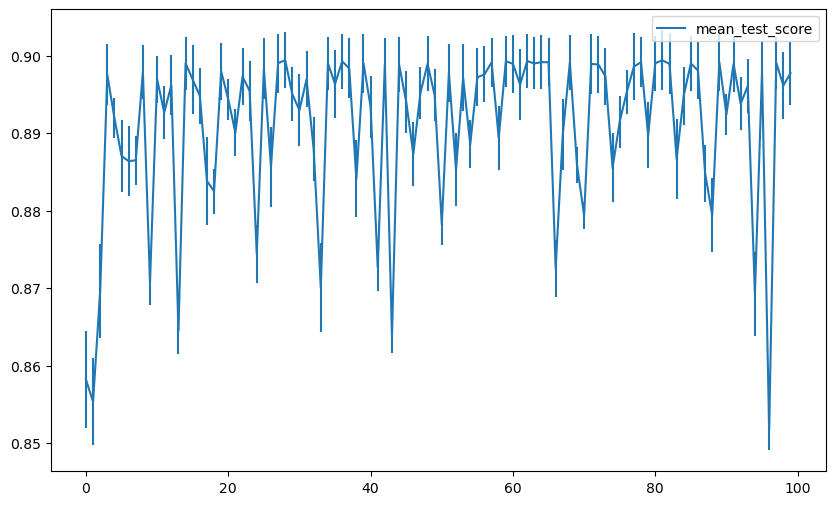

In [36]:
results.plot.line(y='mean_test_score', yerr='std_test_score', figsize=(10, 6));

Error bars show standard deviation across cross-validation folds.

In [37]:
search.best_index_

28

The best result was alread achieved at the 28th trial but it was not possible to predict the number of trials in advance.

### Results
Bayesian search achieves results similar to grid search in 1.3 hours

# Conclusion
- Halving search worked much faster than regular grid search
- ROC AUC was close but lower
- The min_resources parameter should be selected with care, making sure it is not too small.
- Bayesian search achieved better ROC AUC in this case in with a slightly longer search time. 